In [1]:
import pickle
import os
import argparse
import time
import torch
from jax import random
import json
import datetime
from src.losses import sse_loss
from src.helper import compute_num_params, tree_random_normal_like
from src.models.fc import FC_NN
from src.sampling.predictive_samplers import sample_predictive, sample_hessian_predictive
from jax import numpy as jnp
import jax
from jax import flatten_util
import matplotlib.pyplot as plt
import tree_math as tm
import optax

In [2]:
def f(x):
    return jnp.sin(5 * x + 1) #+ jnp.cos(25 * x + 1) + jnp.exp(0.1 * x) + 5


In [3]:
model_key, data_key, noise_key, init_key, split_key = random.split(random.PRNGKey(42), 5)
input_dim = 1
output_dim = 1
n_batches = 50
N = 500
x_train = random.uniform(data_key, (N, input_dim), minval=0, maxval=1)
x_val = jnp.linspace(-1, 2, 100).reshape(-1, 1)
B = int(N / n_batches)
noise_std = 0.01
rho = 1 / noise_std**2
prior_cov = 8.
# log_alpha, log_rho = jnp.log(alpha), jnp.log(rho)
y_train = f(x_train) + random.normal(noise_key, (N, input_dim)) * noise_std
y_train = y_train[:, :output_dim]

# model = FC_NN(output_dim, 15)
model = FC_NN(output_dim, 10, 2)
params = model.init(model_key, x_train[:B])
D = compute_num_params(params)


In [4]:
D

141

In [5]:
p_vec, unravel = jax.flatten_util.ravel_pytree(params)
eps = jax.random.normal(model_key, (10, D))
samples = jax.vmap(lambda e: unravel(e))(eps)

In [6]:
samples['params']['Dense_0']['kernel'].shape

(10, 1, 10)

In [15]:
def mse_loss(preds, y):
    residual = preds - y
    return jnp.mean(residual**2)

def elbo(mu, sigma, key, prior_cov, n_params, x, y, n_samples=1):  
    # if n_samples > 1:
    _, unravel_fn = jax.flatten_util.ravel_pytree(mu)
    # sigma = jax.nn.softplus(sigma)
    eps = jax.random.normal(key, (n_samples, D))#tree_random_normal_like(key, mu, n_samples)
    samples = jax.vmap(lambda e: unravel_fn(sigma @ e))(eps)
    samples = jax.tree_map(lambda m, s: m + s, mu, samples)
    preds = jax.vmap(model.apply, in_axes=(0, None))(samples, x)
    loglik = jax.vmap(mse_loss, in_axes=(0, None))(preds, y).mean()
    # log_prior =  0.5 * (-n_params * jnp.log(2 * jnp.pi) - n_params * jnp.log(prior_cov**2) - 1/prior_cov**2 * 1/n_samples * (tm.Vector(samples) @ tm.Vector(samples)))
    # entropy = 0.5 * (jnp.linalg.slogdet(sigma @ sigma.T)[1] + n_params * (1 + jnp.log(2 * jnp.pi)))
    # else:
        # eps = tree_random_normal_like(key, mu)
        # samples = jax.tree_map(lambda m, s, e: m + jax.nn.softplus(s) * e, mu, sigma, eps)
        # preds = model.apply(samples, x)
        # loglik = mse_loss(preds, y)
    logdet_prior = jax.tree_map(lambda x: jnp.ones_like(x), mu)
    kl = 0
    logdet_pos = jnp.linalg.slogdet(sigma @ sigma.T)[1]
    logdet_prior = jnp.log(prior_cov**2) * n_params
    trace = 1/prior_cov**2 * jnp.trace(sigma @ sigma.T)
    mean = 1/prior_cov**2 * tm.Vector(jax.tree_map(lambda x: x**2, mu)).sum()
    kl = 0.5 * (logdet_pos - logdet_prior + trace + mean - n_params)
    # kl = 0.
    loss = N/B * loglik.mean() + kl
    # loss = loglik - log_prior + entropy
    return loss, (loglik.mean(), kl)

In [16]:
lr = 1e-3
n_epochs = 3000
optim = optax.adam(lr)

mu = tree_random_normal_like(model_key, params)
sigma = 1. * jnp.eye(D)#0.1 * jax.random.normal(model_key, (D, D))
opt_state = optim.init((mu, sigma))


In [17]:
def make_step(mu, sigma, opt_state, key, x, y, n_samples=1):
        grad_fn = jax.value_and_grad(elbo, argnums=(0, 1), has_aux=True)
        loss, grads = grad_fn(mu, sigma, key, prior_cov, D, x, y, n_samples)
        (mu_updates, sigma_updates), opt_state = optim.update(grads, opt_state)
        mu = optax.apply_updates(mu, mu_updates)
        sigma = optax.apply_updates(sigma, sigma_updates)
        return loss, mu, sigma, opt_state
jit_make_step = jax.jit(make_step, static_argnames=("n_samples"))


In [19]:
losses = []
log_likelihoods = []
kls = []
mean_loss = []
mse_preds = []
# Training with Marginal Likelihood loss
print("Starting training...")
for epoch in range(n_epochs):
    start_time = time.time()
    train_key, split_key = random.split(split_key)
    batch_indices_shuffled = random.permutation(train_key, x_train.shape[0])
    for i in range(n_batches):
        train_key, split_key = random.split(split_key)
        x_batch = x_train[batch_indices_shuffled[i * B : (i + 1) * B]]
        y_batch = y_train[batch_indices_shuffled[i * B : (i + 1) * B]]
        loss, mu, sigma, opt_state = jit_make_step(
            mu, sigma, opt_state, train_key, x_batch, y_batch, 50
        )

        loss, (log_likelihood, kl) = loss
        losses.append(loss)
        log_likelihoods.append(log_likelihood.item())
        kls.append(kl.item())
    epoch_time = time.time() - start_time
    log_likelihood_epoch = jnp.mean(jnp.array(log_likelihoods[-B:]))
    epoch_loss = jnp.mean(jnp.array(losses[-B:]))
    epoch_kl = jnp.mean(jnp.array(kls[-B:]))
    print(
        f"epoch={epoch}, log likelihood ={log_likelihood_epoch:.2f}, loss ={epoch_loss:.2f}, kl ={epoch_kl:.2f}, time={epoch_time:.3f}s"
    )


Starting training...
epoch=0, log likelihood =0.33, loss =-496.79, kl =-513.41, time=1.633s
epoch=1, log likelihood =0.29, loss =-506.28, kl =-520.86, time=0.176s
epoch=2, log likelihood =0.31, loss =-505.46, kl =-520.76, time=0.176s
epoch=3, log likelihood =0.31, loss =-501.23, kl =-516.65, time=0.175s
epoch=4, log likelihood =0.27, loss =-500.32, kl =-513.88, time=0.175s
epoch=5, log likelihood =0.33, loss =-497.62, kl =-514.10, time=0.175s
epoch=6, log likelihood =0.31, loss =-495.10, kl =-510.75, time=0.176s
epoch=7, log likelihood =0.34, loss =-487.67, kl =-504.73, time=0.176s
epoch=8, log likelihood =0.30, loss =-494.72, kl =-509.76, time=0.177s
epoch=9, log likelihood =0.26, loss =-506.09, kl =-518.86, time=0.176s
epoch=10, log likelihood =0.29, loss =-493.70, kl =-508.38, time=0.176s
epoch=11, log likelihood =0.27, loss =-505.81, kl =-519.24, time=0.177s
epoch=12, log likelihood =0.36, loss =-500.91, kl =-518.95, time=0.177s
epoch=13, log likelihood =0.32, loss =-486.03, kl =-5

In [20]:
_, unravel_fn = jax.flatten_util.ravel_pytree(mu)
# sigma = jax.nn.softplus(sigma)
eps = jax.random.normal(model_key, (10, D))#tree_random_normal_like(key, mu, n_samples)
samples = jax.vmap(lambda e: unravel_fn(sigma @ e))(eps)
samples = jax.tree_map(lambda m, s: m + s, mu, samples)
preds = jax.vmap(model.apply, in_axes=(0, None))(samples, x_val)


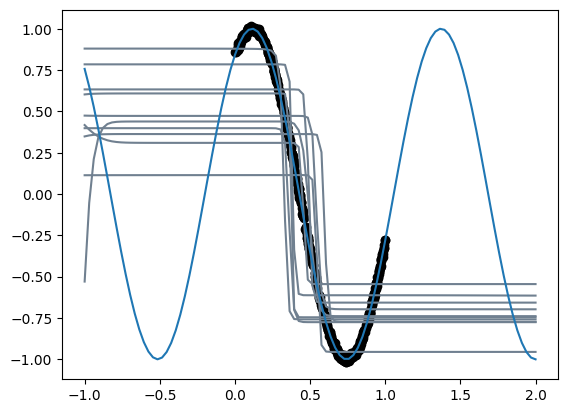

In [21]:
plt.plot(x_val.squeeze(), preds.squeeze().transpose(), label="Predictions", marker="None", color="slategray")
plt.plot(x_val, f(x_val), label="Predictions", marker="None")
plt.scatter(x_train, y_train, label="Training data", color="black")


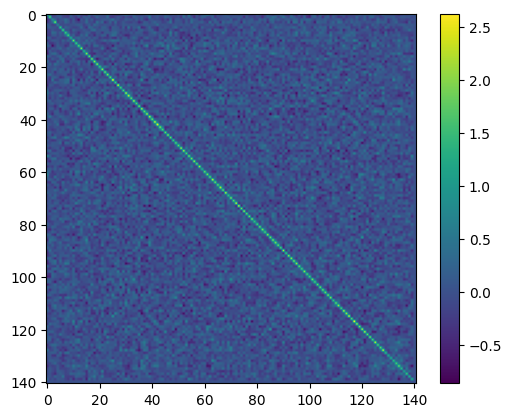

In [24]:
plt.imshow(sigma @ sigma.T, cmap='viridis', interpolation='hermite')
plt.colorbar()